# Active Contour Model
---

The active contour model is a method to fit open or closed splines to lines or edges in an image [1]. It works by minimising an energy that is in part defined by the image and part by the spline’s shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy.

In the following two examples the active contour model is used (1) to segment the face of a person from the rest of an image by fitting a closed curve to the edges of the face and (2) to find the darkest curve between two fixed points while obeying smoothness considerations. Typically it is a good idea to smooth images a bit before analyzing, as done in the following examples.

We initialize a circle around the astronaut’s face and use the default boundary condition boundary_condition='periodic' to fit a closed curve. The default parameters `w_line=0`, `w_edge=1` will make the curve search towards edges, such as the boundaries of the face.

**References**  
[[1](DOI:10.1007/BF00133570)] Snakes: Active contour models. Kass, M.; Witkin, A.; Terzopoulos, D. International Journal of Computer Vision 1 (4): 321 (1988). 

In [260]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data, filters, exposure
from skimage.segmentation import active_contour

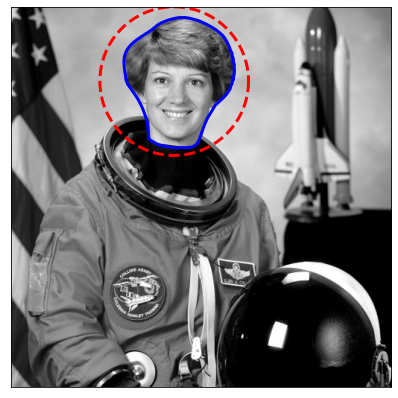

In [3]:
img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(filters.gaussian(img, 3, preserve_range=False),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0]);

## On section images
---

* Enhance contrast
* Sobel edge filtering

In [155]:
from pathlib import Path
from skimage import io, util, color, morphology, restoration

In [5]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [209]:
def process_image(fp, x, y, crop_width=256, pct=1):
    # Aliases
    cw = crop_width

    # Read image
    image = io.imread(fp)
    image = image[y-cw//2:y+cw//2,
                  x-cw//2:x+cw//2]

    # Enhance contrast
    p1, p2 = np.percentile(image, (pct, 100-pct))
    image = exposure.rescale_intensity(image, in_range=(p1, p2))

    return image

In [252]:
# General parameters
cw = 256  # crop width
alpha = 0.1
beta = 0.01
gamma = 0.001
sigma = 3

# Collect filepaths
fps = list(Path('/Users/ryanlane/Documents/development/secdetect/_REPOSITORY/').glob('*.tif'))
fp1 = np.random.RandomState(32).choice(fps, 1)[0]
fp2 = np.random.RandomState(35).choice(fps, 1)[0]

# Load images
x1, y1 = 1830, 1370
image1 = process_image(fp1, x1, y1, pct=0)
x2, y2 = 1990, 1460
image2 = process_image(fp2, x2, y2, pct=0)

# Edge filtering
edges1 = filters.sobel(filters.gaussian(rgb2gray(image1), sigma=sigma))
edges2 = filters.sobel(filters.gaussian(rgb2gray(image2), sigma=sigma))

In [253]:
# Mask for contour finding
s = np.linspace(0, 2*np.pi, 400)
r = cw/2 + 85*np.sin(s)
c = cw/2 + 85*np.cos(s)
init = np.array([r, c]).T

# Compute contours
snake1 = active_contour(filters.gaussian(image1, sigma=sigma),
                        init, alpha=alpha, beta=beta, gamma=gamma)
snake2 = active_contour(filters.gaussian(image2, sigma=sigma),
                        init, alpha=alpha, beta=beta, gamma=gamma)
snake_edges_1 = active_contour(filters.gaussian(edges1, sigma=sigma),
                               init, w_edge=-1, w_line=1, alpha=alpha, beta=beta, gamma=gamma)
snake_edges_2 = active_contour(filters.gaussian(edges2, sigma=sigma),
                               init, w_edge=-1, w_line=1, alpha=alpha, beta=beta, gamma=gamma)
snakes = [snake1, snake_edges_1, snake2, snake_edges_2]

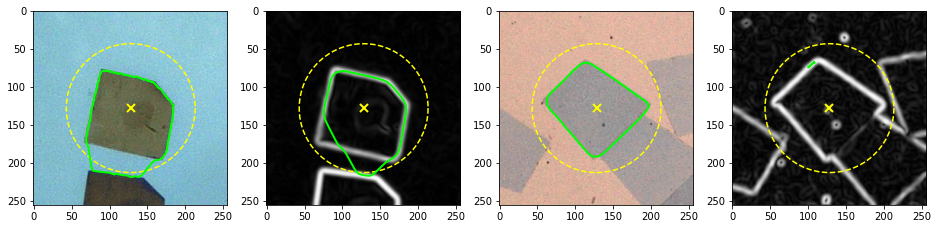

In [254]:
# Create figure
ncols = 4
fig, axes = plt.subplots(ncols=ncols, figsize=(4*ncols, 4))
# Images
axes[0].imshow(image1)
axes[1].imshow(edges1, cmap='Greys_r')
axes[2].imshow(image2)
axes[3].imshow(edges2, cmap='Greys_r')
# Masks
for ax in axes:
    ax.plot(init[:,1], init[:,0], '--', color='#ffff00', label='Guide')
    ax.plot(cw/2, cw/2, 'x', color='#ffff00', ms=8, mew=2)
for i, snake in enumerate(snakes):
    axes[i].plot(snake[:,1], snake[:,0], '-', color='#00ff00', lw=2)

### Serial section example
---

In [269]:
def process_ss_image(fp, coords, crop_width=1024, pct=1):
    # Aliases
    cw = crop_width

    # Read image
    image = io.imread(fp)
    cy, cx, _ = [x//2 for x in image.shape]
    image = image[cy-cw//2:cy+cw//2,
                  cx-cw//2:cx+cw//2,:]

    # Color transformation
    image = color.rgb2hed(image)[:,:,1]

    # Enhance contrast
    p1, p2 = np.percentile(image, (pct, 100-pct))
    image = exposure.rescale_intensity(image, in_range=(p1, p2), out_range=(0, 1))

    # Smooth
#     image = restoration.denoise_bilateral(image, win_size=5)
    footprint = morphology.disk(8)
    image = morphology.opening(image, footprint)

    return image

In [270]:
# Section centroids
coords = [[79, 545],
          [183, 559],
          [284, 566],
          [449, 506],
          [577, 451],
          [650, 520],
          [718, 592],
          [711, 434],
          [246, 672],
          [348, 674],
          [657, 768],
          [589, 865],
          [510, 929]]

# Section image
image = process_ss_image(fp2, coords)

# Edge filtering
edges = filters.sobel(filters.gaussian(image, sigma=sigma))

# Contours
inits = []
snakes = []
for x, y in tqdm(coords):
    # Mask for contour finding
    s = np.linspace(0, 2*np.pi, 400)
    r = y + 85*np.sin(s)
    c = x + 85*np.cos(s)
    init = np.array([r, c]).T
    snake = active_contour(filters.gaussian(image, sigma=sigma),
                           init, alpha=alpha, beta=beta, gamma=gamma)
    inits.append(init)
    snakes.append(snake)

  0%|          | 0/13 [00:00<?, ?it/s]

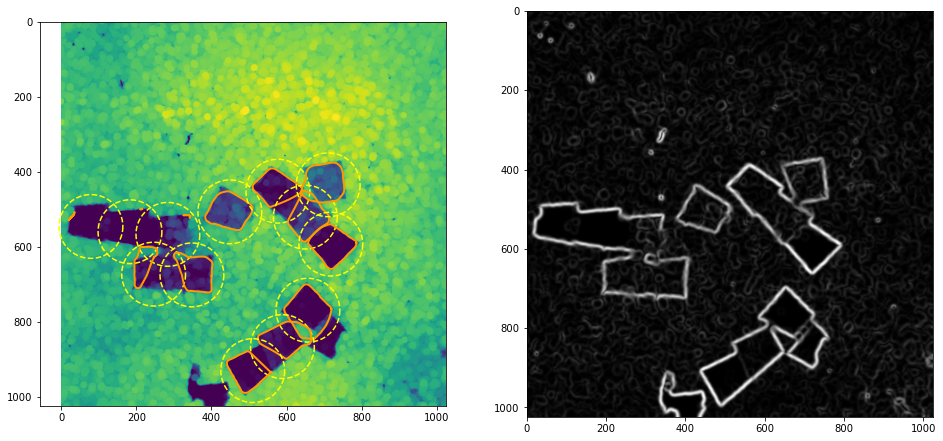

In [271]:
# Create figure
ncols = 2
fig, axes = plt.subplots(ncols=ncols, figsize=(8*ncols, 8))
# Images
axes[0].imshow(image)
axes[1].imshow(edges, cmap='Greys_r')
for init, snake in zip(inits, snakes):
    axes[0].plot(init[:,1], init[:,0], '--', color='#ffff00', label='Guide')
    axes[0].plot(snake[:,1], snake[:,0], '-', color='#ff9900', lw=2)